### <font color='orange'>Notebook du groupe 9 -- Projet numéro 9 NLP1
</font>


## Membre du groupe
    * COMPAORE D Jonathan
    * OUATTARA FAIZA
    * SAWADOGO RAHIMA

### <font color='brown'>Ce script scrape les commentaires d'articles de LeFaso.net et les structure dans un DataFrame
</font>

In [ ]:
#%pip install requests beautifulsoup4 pandas openpyxl tensorflow tf-keras emoji spacy matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#!pip install -q transformers torch

In [ ]:
#!python -m spacy download fr_core_news_sm

#### <font color='blue'>1 - Importations et configuration de base</font>

In [46]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
from datetime import datetime
import re
from typing import Dict, List, Optional, Any
import warnings
import emoji
import spacy
from collections import Counter
from datetime import timedelta
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])

warnings.filterwarnings('ignore')

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
print(tf.__version__)
print("Bibliothèques importées avec succès")

2.20.0
Bibliothèques importées avec succès


#### <font color='blue'>2 - Classe principale du scraper</font>

In [47]:
class LefasoCommentScraper:
    """Classe principale pour scraper les commentaires de LeFaso.net"""

    def __init__(self):
        self.session = requests.Session()
        self._setup_headers()
        self.base_url = "https://lefaso.net"
        self.dataframe = None

    def _setup_headers(self):
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'fr-FR,fr;q=0.8,en-US;q=0.5,en;q=0.3',
        })

    def fetch_page(self, url: str) -> Optional[BeautifulSoup]:
        """Récupère le contenu HTML d'une page"""
        try:
            print(f"Récupération de la page: {url}")
            response = self.session.get(url, timeout=30)
            response.raise_for_status()
            return BeautifulSoup(response.content, 'html.parser')
        except Exception as e:
            print(f"Erreur lors de la récupération: {e}")
            return None

# Test d'initialisation
scraper = LefasoCommentScraper()
print("Scraper initialisé avec succès")

Scraper initialisé avec succès


#### <font color='blue'>3 - Extraction des informations de l'article</font>

In [48]:
def extract_article_info(self, soup: BeautifulSoup, url: str) -> Dict[str, Any]:
    """Extraction des informations principales de l'article"""
    article_info = {
        'titre': 'Non trouvé',
        'url': url,
        'date_publication': 'Non trouvé',
        'categorie': 'Non trouvé',
        'date_scraping': datetime.now().isoformat()
    }

    try:
        # Titre de l'article
        title_elems = soup.find_all('h1', class_='entry-title')
        if len(title_elems) >= 2:
            article_info['titre'] = title_elems[1].get_text(strip=True)
        elif len(title_elems) == 1:
            article_info['titre'] = title_elems[0].get_text(strip=True)
        else:
            print("Aucun h1 avec class='entry-title' trouvé")

        # Date de publication
        for p in soup.find_all('p'):
            text = p.get_text()
            if 'Publié le' in text:
                article_info['date_publication'] = text.replace('Publié le', '').strip()
                break

        # Catégorie
        hierarchie = soup.find('div', id='hierarchie')
        if hierarchie:
            article_info['categorie'] = hierarchie.get_text(strip=True)

    except Exception as e:
        print(f"Erreur extraction infos article: {e}")

    return article_info

# Ajout de la méthode à la classe
LefasoCommentScraper.extract_article_info = extract_article_info
print("Méthode d'extraction d'infos article ajoutée")

Méthode d'extraction d'infos article ajoutée


#### <font color='blue'>4 - Extraction de la section des commentaires</font>

In [49]:
def extract_comments_section(self, soup: BeautifulSoup) -> Optional[BeautifulSoup]:
    """Localisation de la section des commentaires"""
    comments_section = soup.find("ul", id="navforum")
    if comments_section:
        print("Section commentaires trouvée avec find(id='navforum')")
        return comments_section

    selectors = ['ul#navforum', '.forum', '#navforum']
    for selector in selectors:
        section = soup.select_one(selector)
        if section:
            print(f"Section trouvée avec sélecteur: {selector}")
            return section

    print("Aucune section de commentaires trouvée")
    return None

LefasoCommentScraper.extract_comments_section = extract_comments_section
print("Méthode d'extraction de section commentaires ajoutée")

Méthode d'extraction de section commentaires ajoutée


#### <font color='blue'>5 - Parsing des commentaires individuels</font>

In [51]:
def parse_comment_author_date(self, text: str) -> tuple:
    """Extraction de l'auteur et de la date à partir du texte"""
    auteur, date = "Anonyme", "Date inconnue"

    try:
        if 'par' in text and ',' in text:
            parts = text.split('par', 1)[1].split(',', 1)
            auteur = parts[0].strip()
            if len(parts) > 1:
                date = parts[1].strip()
    except:
        pass

    return auteur, date

def extract_comment_content(self, comment_element) -> str:
    """Extraction du contenu textuel d'un commentaire"""
    content_elem = comment_element.find('div', class_='ugccmt-commenttext')
    if content_elem:
        content = content_elem.get_text(strip=True)
        # Nettoyage basique
        content = re.sub(r'\s+', ' ', content)
        return content.strip()
    return ""

def parse_single_comment(self, comment_element, comment_id: int, is_reply: bool = False) -> Optional[Dict[str, Any]]:
    """Parsing d'un commentaire individuel"""
    try:
        # Extraction auteur et date
        chapo_elem = comment_element.find('div', class_='forum-chapo')
        auteur, date = "Anonyme", "Date inconnue"

        if chapo_elem:
            chapo_text = chapo_elem.get_text(strip=True)
            auteur, date = self.parse_comment_author_date(chapo_text)


        # Extraire le contenu
        contenu = self.extract_comment_content(comment_element)

        if not contenu:
            return None

        return {
            'id_commentaire': comment_id,
            'auteur': auteur,
            'date_publication': date,
            'contenu': contenu,
            'type': 'reponse' if is_reply else 'commentaire',
            'longueur_contenu': len(contenu),
            'mots_contenu': len(contenu.split())
        }

    except Exception as e:
        print(f"Erreur parsing commentaire {comment_id}: {e}")
        return None

# Ajout des méthodes à la classe
LefasoCommentScraper.parse_comment_author_date = parse_comment_author_date
LefasoCommentScraper.extract_comment_content = extract_comment_content
LefasoCommentScraper.parse_single_comment = parse_single_comment
print("Méthodes de parsing de commentaires ajoutées")

Méthodes de parsing de commentaires ajoutées


#### <font color='blue'>6 - Extraction des réponses aux commentaires</font>

In [52]:
def extract_replies(self, comment_element, parent_id: int) -> List[Dict[str, Any]]:
    """Extraction des réponses à un commentaire"""
    replies = []

    try:
        replies_list = comment_element.find('ul')
        if replies_list:
            reply_elems = replies_list.find_all('li')

            for i, reply_elem in enumerate(reply_elems, 1):
                reply_data = self.parse_single_comment(reply_elem, i, is_reply=True)
                if reply_data:
                    replies.append(reply_data)
    except Exception as e:
        print(f"Erreur extraction réponses: {e}")

    return replies

LefasoCommentScraper.extract_replies = extract_replies
print("Méthode d'extraction des réponses ajoutée")

Méthode d'extraction des réponses ajoutée


#### <font color='blue'>7 - Méthode principale de scraping</font>

In [53]:
def scrape_article_comments(self, url: str) -> Dict[str, Any]:
    print(f"\nDébut du scraping pour: {url}")

    # Récupération de la page
    soup = self.fetch_page(url)
    if not soup:
        return {'erreur': 'Impossible de récupérer la page', 'url': url}

    # Extraction des informations de l'article
    article_info = self.extract_article_info(soup, url)

    # Localisation de la section des commentaires
    comments_section = self.extract_comments_section(soup)
    if not comments_section:
        article_info['commentaires'] = []
        article_info['statistiques'] = {'total_commentaires': 0, 'total_reponses': 0}
        return article_info

    # Extraction des commentaires principaux
    commentaires_principaux = []
    comment_items = comments_section.find_all('li', class_='forum-fil')

    print(f"{len(comment_items)} commentaire(s) principal(aux) trouvé(s)")

    for i, comment_item in enumerate(comment_items, 1):
        # Parsing du commentaire principal
        comment_data = self.parse_single_comment(comment_item, i)
        if not comment_data:
            continue

        # Extraction des réponses
        reponses = self.extract_replies(comment_item, i)
        comment_data['reponses'] = reponses
        comment_data['nombre_reponses'] = len(reponses)
        commentaires_principaux.append(comment_data)

    # Compiler les statistiques
    total_reponses = sum(comment['nombre_reponses'] for comment in commentaires_principaux)

    result = {
        'article': article_info,
        'commentaires': commentaires_principaux,
        'statistiques': {
            'total_commentaires': len(commentaires_principaux),
            'total_reponses': total_reponses,
            'total_interventions': len(commentaires_principaux) + total_reponses
        }
    }

    print(f"Scraping terminé: {len(commentaires_principaux)} commentaires, {total_reponses} réponses")
    return result

LefasoCommentScraper.scrape_article_comments = scrape_article_comments
print("Méthode principale de scraping ajoutée")

Méthode principale de scraping ajoutée


#### <font color='blue'>8 - Création du DataFrame structuré</font>

In [54]:
def create_dataframe(self, data: Dict[str, Any]) -> pd.DataFrame:
    """Création d'un DataFrame pandas structuré à partir des données scrapées"""
    rows = []
    article_info = data['article']

    # Vérification des commentaires
    if not data.get('commentaires'):
        print("Aucun commentaire à structurer")
        return pd.DataFrame()

    for commentaire in data.get('commentaires', []):
        # Ligne pour le commentaire principal
        row_comment = {
            'id_article': article_info.get('url', 'unknown').split('=')[-1],
            'titre_article': article_info.get('titre', ''),
            'url_article': article_info.get('url', ''),
            'date_publication_article': article_info.get('date_publication', ''),
            'categorie_article': article_info.get('categorie', ''),
            'date_scraping': article_info.get('date_scraping', ''),

            'id_commentaire': f"C{commentaire['id_commentaire']:03d}",
            'id_parent': None,
            'type': 'commentaire',
            'auteur': commentaire['auteur'],
            'date_publication': commentaire['date_publication'],
            'contenu': commentaire['contenu'],
            'longueur_contenu': commentaire['longueur_contenu'],
            'mots_contenu': commentaire['mots_contenu'],
            'nombre_reponses': commentaire.get('nombre_reponses', 0)
        }
        rows.append(row_comment)

        # Lignes pour les réponses
        for reponse in commentaire.get('reponses', []):
            row_reponse = {
                'id_article': article_info.get('url', 'unknown').split('=')[-1],
                'titre_article': article_info.get('titre', ''),
                'url_article': article_info.get('url', ''),
                'date_publication_article': article_info.get('date_publication', ''),
                'categorie_article': article_info.get('categorie', ''),
                'date_scraping': article_info.get('date_scraping', ''),

                'id_commentaire': f"C{commentaire['id_commentaire']:03d}R{reponse['id_commentaire']:02d}",
                'id_parent': f"C{commentaire['id_commentaire']:03d}",
                'type': 'reponse',
                'auteur': reponse['auteur'],
                'date_publication': reponse['date_publication'],
                'contenu': reponse['contenu'],
                'longueur_contenu': reponse['longueur_contenu'],
                'mots_contenu': reponse['mots_contenu'],
                'nombre_reponses': 0
            }
            rows.append(row_reponse)

    self.dataframe = pd.DataFrame(rows)
    return self.dataframe

LefasoCommentScraper.create_dataframe = create_dataframe
print("Méthode de création du DataFrame ajoutée")

Méthode de création du DataFrame ajoutée


#### <font color='blue'>9 - Sauvegarde des données (Excel et JSON)</font>

In [55]:
def save_to_excel(self, data: Dict[str, Any], filename: str = None):
    """Sauvegarde des données dans un fichier Excel"""
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"lefasonet_comments_{timestamp}.xlsx"

    if self.dataframe is None:
        self.create_dataframe(data)

    if self.dataframe.empty:
        print("Aucune donnée à sauvegarder")
        return

    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            self.dataframe.to_excel(writer, sheet_name='Commentaires', index=False)
            stats_df = pd.DataFrame([data['statistiques']])
            stats_df.to_excel(writer, sheet_name='Statistiques', index=False)
            article_df = pd.DataFrame([data['article']])
            article_df.to_excel(writer, sheet_name='Article', index=False)

        print(f"Fichier Excel sauvegardé: {filename}")

    except Exception as e:
        print(f"Erreur sauvegarde Excel: {e}")

def save_to_json(self, data: Dict[str, Any], filename: str = None):
    """Sauvegarde des données dans un fichier JSON"""
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"lefasonet_comments_{timestamp}.json"

    try:
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2, default=str)

        print(f"Fichier JSON sauvegardé: {filename}")

    except Exception as e:
        print(f"Erreur sauvegarde JSON: {e}")

LefasoCommentScraper.save_to_excel = save_to_excel
LefasoCommentScraper.save_to_json = save_to_json
print("Méthodes de sauvegarde ajoutées")

Méthodes de sauvegarde ajoutées


#### <font color='blue'>10 - Affichage des résultats et statistiques</font>

In [56]:
def display_summary(self, data: Dict[str, Any]):
    """Affichage d'un résumé des données scrapées"""
    print("\n" + "="*60)
    print("RÉSUMÉ DU SCRAPING")
    print("="*60)

    if 'erreur' in data:
        print(f"Erreur: {data['erreur']}")
        return

    article = data['article']
    stats = data['statistiques']

    print(f"TITRE: {article.get('titre', 'N/A')}")
    print(f"URL: {article.get('url', 'N/A')}")
    print(f"DATE: {article.get('date_publication', 'N/A')}")
    print(f"CATÉGORIE: {article.get('categorie', 'N/A')}")
    print(f"COMMENTAIRES: {stats.get('total_commentaires', 0)}")
    print(f"RÉPONSES: {stats.get('total_reponses', 0)}")
    print(f"TOTAL: {stats.get('total_interventions', 0)} interventions")

LefasoCommentScraper.display_summary = display_summary
print("Méthode d'affichage ajoutée")

Méthode d'affichage ajoutée


#### <font color='blue'>12 - EXÉCUTION AVEC URL PERSONNALISÉE</font>

In [57]:
def scraper_interactif():
    """Version interactive pour scraper n'importe quelle URL"""
    print("SCRAPER INTERACTIF LeFaso.net")
    print("=" * 40)

    # Demande de l'URL
    url = input("Entrez l'URL de l'article LeFaso.net: ").strip()

    if not url.startswith('http'):
        url = 'https://' + url

    # Initialisation et exécution
    scraper = LefasoCommentScraper()
    data = scraper.scrape_article_comments(url)

    if 'erreur' in data:
        print(f"Erreur: {data['erreur']}")
        return

    scraper.display_summary(data)
    df = scraper.create_dataframe(data)

    if not df.empty:
        print(f"\nDataFrame: {len(df)} lignes")

        # Sauvegarder
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        scraper.save_to_excel(data, f"lefaso_{timestamp}.xlsx")
        scraper.save_to_json(data, f"lefaso_{timestamp}.json")

        return df
    else:
        print("Aucune donnée extraite")
        return None

# Décommenter la ligne suivante pour utiliser le mode interactif
# df_resultat = scraper_interactif()

#### <font color='blue'>13 - Scraping multiple d'URLs</font>

In [58]:
def scraper_multiple_urls(urls):
    """
    Scrape plusieurs URLs et combine les résultats
    """
    scraper = LefasoCommentScraper()
    all_data = []

    print("DÉBUT DU SCRAPING MULTIPLE")
    print("=" * 50)

    for i, url in enumerate(urls, 1):
        print(f"\nTraitement de l'URL {i}/{len(urls)}: {url}")

        data = scraper.scrape_article_comments(url)
        if data and data.get('commentaires'):
            all_data.append(data)
            print(f"Article {i} scrapé avec succès")
        else:
            print(f"Échec du scraping pour l'article {i}")

    if not all_data:
        print("Aucune donnée récupérée")
        return pd.DataFrame()

    # Combiner tous les DataFrames
    combined_df = pd.DataFrame()
    for j, data in enumerate(all_data, 1):
        print(f"Structuration des données de l'article {j}/{len(all_data)}...")
        df = scraper.create_dataframe(data)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Statistiques finales
    total_commentaires = combined_df[combined_df['type'] == 'commentaire'].shape[0]
    total_reponses = combined_df[combined_df['type'] == 'reponse'].shape[0]

    # Sauvegarder le résultat combiné
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    excel_filename = f"lefaso_comments_combined_{timestamp}.xlsx"
    json_filename = f"lefaso_comments_combined_{timestamp}.json"

    # Sauvegarde Excel
    try:
        with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
            combined_df.to_excel(writer, sheet_name='Tous_Commentaires', index=False)

            # Ajouter un onglet avec les statistiques par article
            stats_by_article = combined_df.groupby('id_article').agg({
                'titre_article': 'first',
                'type': 'count',
                'auteur': 'nunique'
            }).rename(columns={'type': 'total_interventions', 'auteur': 'auteurs_uniques'})
            stats_by_article.to_excel(writer, sheet_name='Stats_Articles')

        print(f"Fichier Excel sauvegardé: {excel_filename}")
    except Exception as e:
        print(f"Erreur sauvegarde Excel: {e}")

    # Sauvegarde JSON
    try:
        combined_df.to_json(json_filename, orient='records', force_ascii=False, indent=2)
        print(f"Fichier JSON sauvegardé: {json_filename}")
    except Exception as e:
        print(f"Erreur sauvegarde JSON: {e}")

    # Résumé final
    print(f"\nSCRAPING MULTIPLE TERMINÉ!")
    print("=" * 40)
    print(f"Articles traités: {len(all_data)}")
    print(f"Commentaires principaux: {total_commentaires}")
    print(f"Réponses: {total_reponses}")
    print(f"Total interventions: {len(combined_df)}")
    print(f"Auteurs uniques: {combined_df['auteur'].nunique()}")
    print(f"Période couverte: {combined_df['date_publication_article'].nunique()} dates différentes")

    return combined_df

In [59]:
# Option pour exécuter le scraping multiple
def lancer_scraping_multiple(urls):
    """Fonction pour lancer le scraping multiple"""
    print("Lancement du scraping multiple...")
    df_resultat = scraper_multiple_urls(urls)

    if not df_resultat.empty:
        print(f"\nAPERÇU DES DONNÉES COMBINÉES:")
        print(f"Dimensions: {df_resultat.shape[0]} lignes × {df_resultat.shape[1]} colonnes")
        print(f"\nRÉPARTITION PAR ARTICLE:")
        repartition = df_resultat['id_article'].value_counts()
        for article_id, count in repartition.items():
            titre = df_resultat[df_resultat['id_article'] == article_id]['titre_article'].iloc[0]
            print(f"• {article_id}: {count} interventions - {titre[:50]}...")

    return df_resultat


#### <font color='blue'>14 : Fonctions utilitaires supplémentaires</font>

In [60]:
def analyser_donnees_combinees(df):
    """Analyse des données combinées pour des insights"""
    if df is None or df.empty:
        print("Aucune donnée à analyser")
        return

    print("ANALYSE DES DONNÉES COMBINÉES")
    print("=" * 50)

    # Statistiques de base
    print(f"Données combinées: {len(df)} interventions")
    print(f"Articles: {df['id_article'].nunique()}")
    print(f"Auteurs uniques: {df['auteur'].nunique()}")
    print(f"Commentaires: {df[df['type'] == 'commentaire'].shape[0]}")
    print(f"Réponses: {df[df['type'] == 'reponse'].shape[0]}")

    # Top auteurs
    print(f"\nTOP 10 DES AUTEURS LES PLUS ACTIFS:")
    top_auteurs = df['auteur'].value_counts().head(10)
    for auteur, count in top_auteurs.items():
        print(f"  {auteur}: {count} interventions")

    # Longueur moyenne des commentaires
    longueur_moyenne = df['longueur_contenu'].mean()
    mots_moyens = df['mots_contenu'].mean()
    print(f"\nLONGUEUR MOYENNE:")
    print(f"  Caractères: {longueur_moyenne:.1f}")
    print(f"  Mots: {mots_moyens:.1f}")

    # Articles avec le plus d'engagement
    print(f"\nARTICLES LES PLUS COMMENTÉS:")
    articles_populaires = df['id_article'].value_counts().head(5)
    for article_id, count in articles_populaires.items():
        titre = df[df['id_article'] == article_id]['titre_article'].iloc[0]
        print(f"  {article_id}: {count} interventions - {titre[:60]}...")

print("Fonctions utilitaires ajoutées")

Fonctions utilitaires ajoutées


In [61]:
def clean_comment(text: str) -> str:
    """
    Nettoie et normalise un commentaire :
    - Conversion des emojis en texte lisible (:thumbs_up:)
    - Suppression des URLs, mentions et hashtags
    - Suppression des caractères spéciaux et chiffres inutiles
    - Réduction des espaces multiples
    - Lemmatisation (SpaCy) avec suppression des stopwords
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    # 1. Convertir les emojis en texte
    text = emoji.demojize(text, delimiters=(" ", " "))

    # 2. Supprimer les URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # 3. Supprimer les mentions et hashtags
    text = re.sub(r"[@#]\w+", " ", text)

    # 4. Supprimer les caractères spéciaux (on garde les lettres et accents)
    text = re.sub(r"[^a-zA-ZÀ-ÿ\s]", " ", text)

    # 5. Réduire les espaces multiples
    text = re.sub(r"\s+", " ", text).strip()

    # 6. Lemmatisation avec suppression des stopwords
    doc = nlp(text.lower())
    text_lem = " ".join(
        [token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
    )

    return text_lem

print("Fonctions de nétoyage ajouté")

Fonctions de nétoyage ajouté


In [62]:
def nettoyer_dataframe(df, colonne_texte="contenu"):
    """
    Applique le nettoyage à tous les commentaires du DataFrame
    et crée une nouvelle colonne 'contenu_propre'
    """
    if df is None or df.empty:
        print("Aucune donnée à nettoyer")
        return df

    print("NETTOYAGE DES COMMENTAIRES EN COURS...")
    df['contenu_propre'] = df[colonne_texte].apply(clean_comment)

    # Calculer la longueur et le nombre de mots après nettoyage
    df['longueur_propre'] = df['contenu_propre'].apply(len)
    df['mots_propre'] = df['contenu_propre'].apply(lambda x: len(x.split()))

    print("Nettoyage terminé")
    return df


#### <font color='blue'>14 : Fonctions d'analyse des sentiments</font>

In [63]:
class AnalyticsNotebook:
    """Classe pour analyser les commentaires dans un notebook Jupyter / Colab avec TensorFlow"""

    def __init__(self, df):
        """
        df : DataFrame contenant les commentaires
        Colonnes attendues : ['id_article', 'titre_article', 'contenu_propre', 'auteur', 'date_extraction']
        """
        self.df = df
        self.sentiment_analyzer = None
        self.initialize_sentiment_analyzer()

    def initialize_sentiment_analyzer(self):
        """Initialise le modèle TF Allociné"""
        try:
            model_name = "tblard/camembert-base-sentiment"
            self.sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model=model_name,
                tokenizer=model_name,
                framework="pt"
            )
            print("Modèle BERT initialisé")
        except Exception as e:
            print(f"Erreur init BERT: {e}, fallback...")
            try:
                self.sentiment_analyzer = pipeline("sentiment-analysis")
                print("Modèle fallback initialisé (distilbert)")
            except Exception as e2:
                print(f"Erreur fallback: {e2}")
                self.sentiment_analyzer = None

    def get_sentiment_bert(self, text: str):
        """Analyse le sentiment d'un texte"""
        if not self.sentiment_analyzer or not text:
            return {'label': 'NEUTRE', 'score': 0.5}

        if len(text) > 512:
            text = text[:512]

        result = self.sentiment_analyzer(text)[0]

        # Harmonisation des labels
        label_map = {
            'positive': 'POSITIF',
            'negative': 'NEGATIF',
            'neutral': 'NEUTRE',
            'POS': 'POSITIF',
            'NEG': 'NEGATIF',
            'NEU': 'NEUTRE'
        }
        label = label_map.get(result['label'], result['label'].upper())
        return {'label': label, 'score': float(result['score'])}

    def get_sentiment_score(self, label, score):
        """Convertit label → score numérique"""
        mapping = {'POSITIF': score, 'NEGATIF': -score, 'NEUTRE': 0.0}
        return mapping.get(label.upper(), 0.0)

    def analyze_sentiments(self):
        """Ajoute les sentiments et scores au DataFrame"""
        sentiments = []
        scores = []
        for text in self.df['contenu_propre']:
            sentiment = self.get_sentiment_bert(text)
            sentiments.append(sentiment['label'])
            scores.append(self.get_sentiment_score(sentiment['label'], sentiment['score']))
        self.df['sentiment'] = sentiments
        self.df['score'] = scores
        return self.df

    def get_summary(self):
        """Retourne un résumé global des sentiments"""
        if 'sentiment' not in self.df:
            self.analyze_sentiments()

        total = len(self.df)
        if total == 0:
            return {'positif': 0, 'negatif': 0, 'neutre': 100, 'moyen': 0, 'total': 0}

        positif = (self.df['sentiment'] == 'POSITIVE').mean() * 100
        negatif = (self.df['sentiment'] == 'NEGATIVE').mean() * 100
        neutre = (self.df['sentiment'] == 'NEUTRAL').mean() * 100
        score_moyen = ((self.df['score'].mean() + 1) / 2) * 100

        return {
            'positif': round(positif, 1),
            'negatif': round(negatif, 1),
            'neutre': round(neutre, 1),
            'moyen': round(score_moyen, 1),
            'total': total
        }

    def get_word_frequency(self, limit=50):
      # Activation de l'affichage inline (utile dans Jupyter/Colab)
    #   try:
    #       get_ipython().run_line_magic("matplotlib", "inline")
    #   except:
    #       pass

      nltk.download("stopwords", quiet=True)
      stop_words = stopwords.words("french")

      # Copie du dataframe
      df = self.df.copy()
      df["contenu_propre"] = df["contenu_propre"].astype(str)

      # Vectorisation
      vectorizer = CountVectorizer(
          ngram_range=(1, 2),
          max_features=limit,
          stop_words=stop_words,
          strip_accents="unicode"
      )
      X = vectorizer.fit_transform(df["contenu_propre"])

      # Calcul des fréquences
      freqs = X.toarray().sum(axis=0)
      words = vectorizer.get_feature_names_out()

      # DataFrame des mots fréquents
      freq_df = pd.DataFrame({"mot": words, "frequence": freqs}).sort_values(
          by="frequence", ascending=False
      )

      print("Top mots-clés :")
      print(freq_df.head(10))

      # Génération du nuage de mots
      wordcloud = WordCloud(
          width=800, height=400, background_color="white"
      ).generate_from_frequencies(dict(zip(words, freqs)))

      plt.figure(figsize=(10, 5))
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show(block=True)  # force l'affichage même hors notebook
      plt.close()           # évite le "double plot" dans Colab

    #   return freq_df



    def get_activity_timeline(self, days=30):
        """Chronologie des commentaires sur les derniers `days` jours"""
        df = self.df.copy()
        df['date'] = pd.to_datetime(df['date_extraction']).dt.date
        timeline = df['date'].value_counts().sort_index()
        return timeline.tail(days)

    def get_top_authors(self, limit=10):
        """Auteurs les plus actifs"""
        return self.df['auteur'].value_counts().head(limit)

## <font color='orange'>16 : Execution du projet</font>

In [66]:

# Liste d'URLs à scraper
urls = [
    "https://lefaso.net/spip.php?article137593",
    "https://lefaso.net/spip.php?article124600",
    "https://lefaso.net/spip.php?article111192",
    "https://lefaso.net/spip.php?article119046",
    "https://lefaso.net/spip.php?article122867",
    "https://lefaso.net/spip.php?article133172",
    "https://lefaso.net/spip.php?article137090",
    "https://lefaso.net/spip.php?article133365",
    "https://lefaso.net/spip.php?article137611",
    "https://lefaso.net/spip.php?article116538",
    "https://lefaso.net/spip.php?article134992",
    "https://lefaso.net/spip.php?article140484"
]

In [67]:
# 1. Scraping
print("=== ========================================================================================== ===")
print("=== SCRAPING ===")
df_final = lancer_scraping_multiple(urls)
analyser_donnees_combinees(df_final)

=== ========================================================================================== ===
=== SCRAPING ===
Lancement du scraping multiple...
DÉBUT DU SCRAPING MULTIPLE

Traitement de l'URL 1/12: https://lefaso.net/spip.php?article137593

Début du scraping pour: https://lefaso.net/spip.php?article137593
Récupération de la page: https://lefaso.net/spip.php?article137593
Section commentaires trouvée avec find(id='navforum')
5 commentaire(s) principal(aux) trouvé(s)
Scraping terminé: 5 commentaires, 1 réponses
Article 1 scrapé avec succès

Traitement de l'URL 2/12: https://lefaso.net/spip.php?article124600

Début du scraping pour: https://lefaso.net/spip.php?article124600
Récupération de la page: https://lefaso.net/spip.php?article124600
Section commentaires trouvée avec find(id='navforum')
20 commentaire(s) principal(aux) trouvé(s)
Scraping terminé: 20 commentaires, 38 réponses
Article 2 scrapé avec succès

Traitement de l'URL 3/12: https://lefaso.net/spip.php?article111192

Débu

In [68]:
# 2. Nettoyage
print("=== ========================================================================================== ===")
print("=== NETOYAGE ===")
df_clean = nettoyer_dataframe(df_final, colonne_texte="contenu")
df_clean.to_csv("lefaso_comments_clean.csv", index=False, encoding="utf-8-sig")
print(f"DataFrame nettoyé exporté avec succès dans : lefaso_comments_clean.csv")
print(df_clean[['contenu', 'contenu_propre']].head(10))

=== ========================================================================================== ===
=== NETOYAGE ===
NETTOYAGE DES COMMENTAIRES EN COURS...
Nettoyage terminé
DataFrame nettoyé exporté avec succès dans : lefaso_comments_clean.csv
                                             contenu  \
0  C’est dommage que l’on soit encore dans un con...   
1  Salut Indjaba, la reponse est simple, ce sont ...   
2  Mon soutien indefectible et sans ambage au pre...   
3  Félicitations à la veille citoyenne (cnavc), e...   
4  On déplore qu’il y ait des tentatives de coups...   
5  Quand on a pas un minimum pour tirer une concl...   
6  On ne veut plus de coup d’État dans ce pays. L...   
7  Le Burkina Fao n’en serait pas là si Damiba et...   
8  Bonjour indjaba, bonjour Amors, Pour aller dan...   
9  kwiliga "aurait pu être rédigée fin janvier 20...   

                                      contenu_propre  
0  c dommage l contexte pensent coup d état c fai...  
1  salut indjaber reponse sim

In [69]:
# 3. Lancer l’analyse
print("=== ========================================================================================== ===")
print("=== ANALYSE ===")
analytics = AnalyticsNotebook(df_clean)
# Ajout des sentiments dans df
df_analysed = analytics.analyze_sentiments()
df_analysed.to_csv("Df analysé.csv", index=False, encoding="utf-8-sig")

=== ========================================================================================== ===
=== ANALYSE ===


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Erreur init BERT: tblard/camembert-base-sentiment is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`, fallback...


Device set to use cpu


Modèle fallback initialisé (distilbert)


In [70]:
# 4. Résumé global
resume = analytics.get_summary()
print("=== ========================================================================================== ===")
print("=== RÉSUMÉ GLOBAL ===")
print(resume)

=== ========================================================================================== ===
=== RÉSUMÉ GLOBAL ===
{'positif': np.float64(13.4), 'negatif': np.float64(86.6), 'neutre': np.float64(0.0), 'moyen': np.float64(50.0), 'total': 209}



=== MOTS FRÉQUENTS ===
=== ========================================================================================== ===
Top mots-clés :
          mot  frequence
34       pays        114
13       etat         95
14       etre         80
3        bien         76
35     peuple         70
5     burkina         67
16      faire         63
9        coup         62
6   burkinabe         59
1     afrique         57


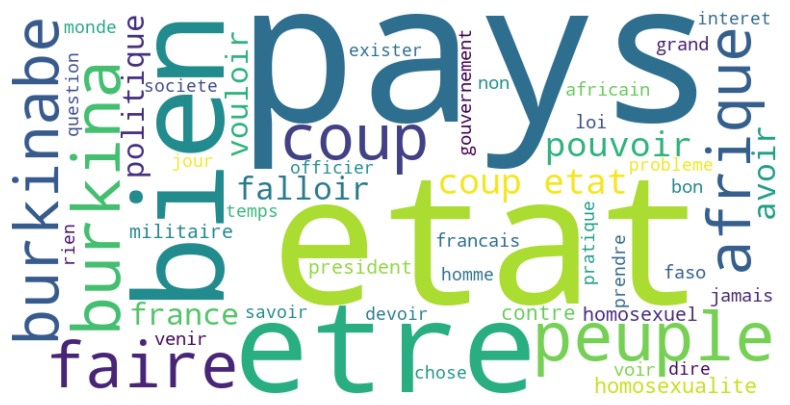

None


In [71]:
# 5. Mots fréquents
print("\n=== MOTS FRÉQUENTS ===")
print("=== ========================================================================================== ===")
print(analytics.get_word_frequency())

In [72]:
# 7. Top auteurs
print("\n=== TOP AUTEURS ===")
print("=== ========================================================================================== ===")
print(analytics.get_top_authors(10))


=== TOP AUTEURS ===
=== ========================================================================================== ===
auteur
SOME                 16
jan jan              12
kwiliga              10
Renault HÉLIE         7
Passakziri            6
Bob                   6
Gwandba               4
Anonyme               4
Dieudonne Tamini      4
Anaarchiqqukement     4
Name: count, dtype: int64


In [73]:
# 8. Aperçu DataFrame avec sentiments
print("=== ========================================================================================== ===")
print("\n=== APERÇU DU DF AVEC SENTIMENTS ===")
print(df_analysed[['id_article', 'contenu_propre', 'sentiment', 'score']].head(10))

=== ========================================================================================== ===

=== APERÇU DU DF AVEC SENTIMENTS ===
                                  id_article  \
0  https://lefaso.net/spip.php?article137593   
1  https://lefaso.net/spip.php?article137593   
2  https://lefaso.net/spip.php?article137593   
3  https://lefaso.net/spip.php?article137593   
4  https://lefaso.net/spip.php?article137593   
5  https://lefaso.net/spip.php?article137593   
6  https://lefaso.net/spip.php?article124600   
7  https://lefaso.net/spip.php?article124600   
8  https://lefaso.net/spip.php?article124600   
9  https://lefaso.net/spip.php?article124600   

                                      contenu_propre sentiment  score  
0  c dommage l contexte pensent coup d état c fai...  NEGATIVE    0.0  
1  salut indjaber reponse simple imperialiste vou...  NEGATIVE    0.0  
2  soutien indefectibl ambage president excellenc...  NEGATIVE    0.0  
3  félicitatier veille citoyen cnavc omettre w